In [33]:
import pandas as pd
from tensorflow.keras.models import load_model
import yfinance as yf
from pickle import load
from datetime import datetime, timedelta
from numpy import array as np_array, concatenate, zeros


MODEL_PATH = "/Users/nik/PycharmProjects/sibyl/backend/src/oracle/models/oracle_v0.1.keras"
SCALER_PATH = "/Users/nik/PycharmProjects/sibyl/backend/src/oracle/preprocessing/minmax_scaler-7f.pkl"


class Oracle:
    def __init__(self):
        self.lookback = 60  # days
        self.forecast_horizon = 7  # days
        self.model = load_model(MODEL_PATH)
        self.scaler = load(open(SCALER_PATH, 'rb'))
        self.dataset = pd.DataFrame()
        self.model_input = None
        self.current_btc_price = None
        
        
    def fetch_dataset(self):

        start_date = (datetime.today() - timedelta(days=self.lookback)).strftime('%Y-%m-%d')
        end_date = datetime.today().strftime('%Y-%m-%d')

        bitcoin = yf.download('BTC-USD', start=start_date, end=end_date)
        self.dataset['bitcoin_price'] = bitcoin['Adj Close']
        self.current_btc_price = self.dataset['bitcoin_price'].values
        sp500 = yf.download('^GSPC', start=start_date, end=end_date)
        self.dataset['sp500_price'] = sp500['Adj Close']
        gold = yf.download('GC=F', start=start_date, end=end_date)
        self.dataset['gold_price'] = gold['Adj Close']
        usd_index = yf.download('DX-Y.NYB', start=start_date, end=end_date)
        self.dataset['usd_index'] = usd_index['Adj Close']
        vol_index = yf.download('^VIX', start=start_date, end=end_date)
        self.dataset['volatility_index'] = vol_index['Adj Close']
        irx = yf.download('^IRX', start=start_date, end=end_date)
        self.dataset['interest_rate'] = irx['Adj Close']
        oil = yf.download('CL=F', start=start_date, end=end_date)
        self.dataset['oil_price'] = oil['Adj Close']

        self.dataset.ffill(inplace=True)
        self.dataset.dropna(inplace=True)

    def dataset_preprocessing(self):
        self.dataset = self.scaler.transform(self.dataset[['bitcoin_price', 'sp500_price', 'gold_price', 'usd_index', 'oil_price',
                                               'volatility_index', 'interest_rate']])
        
    def create_model_input(self):            
        self.model_input = self.dataset.reshape(1, self.lookback, self.dataset.shape[1])
    
    def generate_model_prediction(self):
        y_pred = self.model.predict(self.model_input)
        dummy_2d_array = zeros((self.forecast_horizon, 7))
        dummy_2d_array[:, 0] = y_pred[0]
        rescaled_2d_array = self.scaler.inverse_transform(dummy_2d_array)
        return rescaled_2d_array[:, 0]
    
    def generate_btc_prediction(self):
        self.fetch_dataset()
        self.dataset_preprocessing()
        self.create_model_input()
        y_pred = self.generate_model_prediction()
        return self.current_btc_price, y_pred

In [34]:
client = Oracle()
a = client.generate_btc_prediction()
print(a)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
(array([58127.01171875, 60571.30078125, 60005.12109375, 59182.8359375 ,
       58192.5078125 , 60308.5390625 , 61649.6796875 , 62940.45703125,
       63192.9765625 , 63394.83984375, 63648.7109375 , 63329.80078125,
       64301.96875   , 63143.14453125, 65181.01953125, 65790.6640625 ,
       65887.6484375 , 65635.3046875 , 63329.5       , 60837.0078125 ,
       60632.78515625, 60759.40234375, 62067.4765625 , 62089.94921875,
       62818.953125  , 62236.66015625, 62131.96875   , 60582.1015625 ,
       60274.5       , 62445.08984375, 63193.0234375 , 62851.375     ,
       66046.125     , 67041.109375  , 67612.71875   , 67399.8359375 ,
       68418.7890625 , 68362.734375  , 69001.703125  , 67367.8515625 ,
       67361.40625   , 66432.1953125 , 68161.0546875 , 66642.4140625 ,
       67014.6953125 , 67929.296875  , 69907.7578125 , 72720.4921875 ,
       72339.5390625 , 70215.1875    , 69482.46875   , 69289.2734375 ,
       68741.1171875 , 67811.5078125 

In [38]:
b = list(a[0]) + list(a[1])
print(b)

[58127.01171875, 60571.30078125, 60005.12109375, 59182.8359375, 58192.5078125, 60308.5390625, 61649.6796875, 62940.45703125, 63192.9765625, 63394.83984375, 63648.7109375, 63329.80078125, 64301.96875, 63143.14453125, 65181.01953125, 65790.6640625, 65887.6484375, 65635.3046875, 63329.5, 60837.0078125, 60632.78515625, 60759.40234375, 62067.4765625, 62089.94921875, 62818.953125, 62236.66015625, 62131.96875, 60582.1015625, 60274.5, 62445.08984375, 63193.0234375, 62851.375, 66046.125, 67041.109375, 67612.71875, 67399.8359375, 68418.7890625, 68362.734375, 69001.703125, 67367.8515625, 67361.40625, 66432.1953125, 68161.0546875, 66642.4140625, 67014.6953125, 67929.296875, 69907.7578125, 72720.4921875, 72339.5390625, 70215.1875, 69482.46875, 69289.2734375, 68741.1171875, 67811.5078125, 69359.5625, 75639.078125, 75904.859375, 76545.4765625, 76778.8671875, 80325.9609375, 68271.65758326987, 67554.35364808922, 67167.45559797449, 67346.02252394703, 67257.84854096617, 67839.2343268429, 67079.1355106307

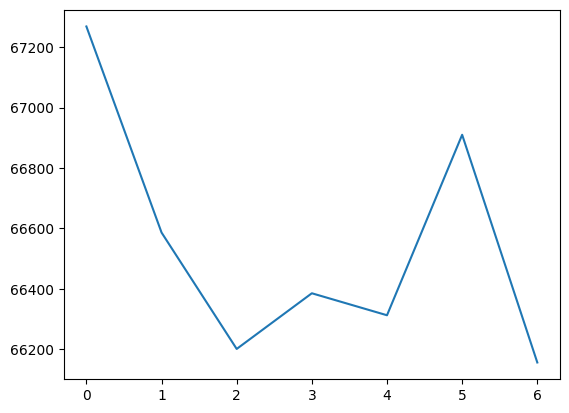

In [31]:
import matplotlib.pyplot as plt
plt.plot(a[1])

In [66]:

# Generate the list of dictionaries with date and price
result = []
time_diff = len(b)
for i, price in enumerate(b):
    result.append({"date": (datetime.today() - timedelta(days=time_diff)).strftime('%Y-%m-%d'), "price": price})
    time_diff -= 1

# Generate the list of date and price data
import plotly.graph_objects as go

# Convert to a DataFrame for Plotly
df = pd.DataFrame(result)

fig = go.Figure()

# Plot actual data
fig.add_trace(go.Scatter(x=df[0:60]['date'], y=df[0:60]['price'],
                         mode='lines', name='Actual',
                         line=dict(color='blue', width=2)))

# Plot predicted data
fig.add_trace(go.Scatter(x=df[59:-1]['date'], y=df[59:-1]['price'],
                         mode='lines+markers', name='Prediction',
                         line=dict(color='rgba(255, 165, 0, 0.8)', width=2, shape='spline'),  # Smooth curve with transparency
                         marker=dict(size=6, color='orange', symbol='circle', line=dict(width=2, color='black')),
                         fill='tonexty', fillcolor='rgba(255, 165, 0, 0.2)'))  # Gradient-like effect


# Update layout
fig.update_layout(
    title='Price and Oracle Prediction',
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis_tickangle=-45,
    hovermode='closest'  # Smooth hover interaction
)

# Show the plot
fig.show()

In [70]:
result = []
time_diff = len(b)-7
for i, price in enumerate(b):
    result.append({"date": (datetime.today() - timedelta(days=time_diff)).strftime('%Y-%m-%d'), "price": price})
    time_diff -= 1
result

[{'date': '2024-09-12', 'price': 58127.01171875},
 {'date': '2024-09-13', 'price': 60571.30078125},
 {'date': '2024-09-14', 'price': 60005.12109375},
 {'date': '2024-09-15', 'price': 59182.8359375},
 {'date': '2024-09-16', 'price': 58192.5078125},
 {'date': '2024-09-17', 'price': 60308.5390625},
 {'date': '2024-09-18', 'price': 61649.6796875},
 {'date': '2024-09-19', 'price': 62940.45703125},
 {'date': '2024-09-20', 'price': 63192.9765625},
 {'date': '2024-09-21', 'price': 63394.83984375},
 {'date': '2024-09-22', 'price': 63648.7109375},
 {'date': '2024-09-23', 'price': 63329.80078125},
 {'date': '2024-09-24', 'price': 64301.96875},
 {'date': '2024-09-25', 'price': 63143.14453125},
 {'date': '2024-09-26', 'price': 65181.01953125},
 {'date': '2024-09-27', 'price': 65790.6640625},
 {'date': '2024-09-28', 'price': 65887.6484375},
 {'date': '2024-09-29', 'price': 65635.3046875},
 {'date': '2024-09-30', 'price': 63329.5},
 {'date': '2024-10-01', 'price': 60837.0078125},
 {'date': '2024-10-0